# Calibration of dataset 123

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import py4DSTEM
from py4DSTEM.visualize import show
from os import path 
import ncempy

In [2]:
filepath_calibation_data = "/media/AuxDriveB/Data/HadasSternlicht/conductive_polymers/500C/dataset_123_aluminumStandard/dataset_123.dm4"
filepath_vacuum_probe = "/media/AuxDriveB/Data/HadasSternlicht/conductive_polymers/500C/dataset_141_vacuumScan/dataset_141.dm4"
filepath_calibration_h5 = "/media/AuxDriveB/Data/HadasSternlicht/conductive_polymers/500C/dataset_123_aluminumStandard/calibrations_from_dataset123.h5"

## Load data

In [3]:
datacube = py4DSTEM.io.read(filepath_calibation_data)
datacube = py4DSTEM.io.datastructure.DataCube(data=datacube[0:15,0:20,:,:])
datacube.data.shape

(15, 20, 864, 864)

## Examine the data

In [4]:
dp_max = datacube.get_dp_max()
dp_mean = datacube.get_dp_mean()
dp_median = datacube.get_dp_median()

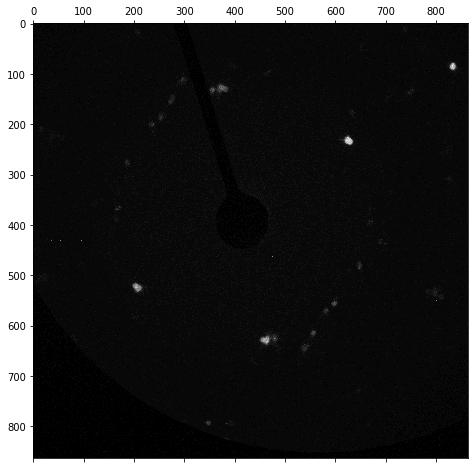

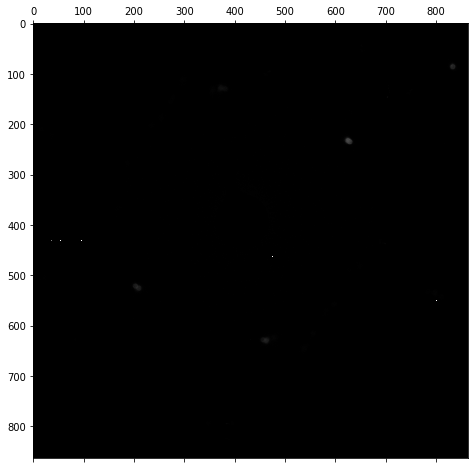

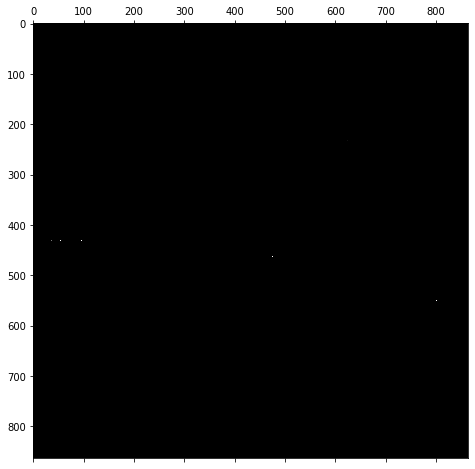

In [5]:
show(dp_max.data)
show(dp_mean.data)
show(dp_median.data)

In [6]:
datacube.tree

ParentTree( An object tree containing the following top-level object instances:

                calibration 		 (Calibration)
                dp_max 		 (DiffractionImage)
                dp_mean 		 (DiffractionImage)
                dp_median 		 (DiffractionImage)
)

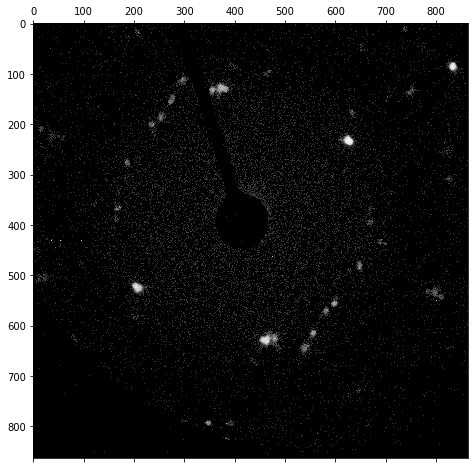

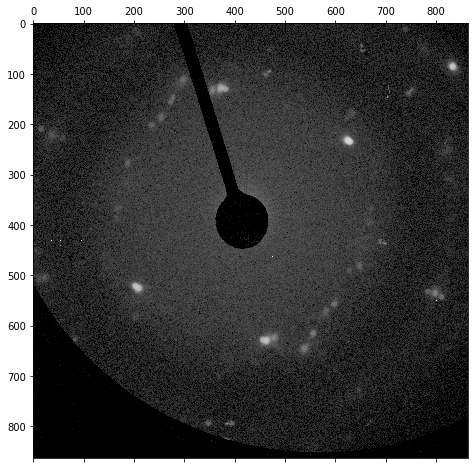

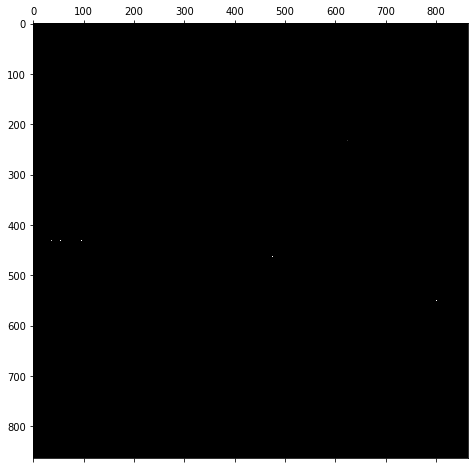

In [7]:
show(datacube.tree['dp_max'].data, scaling='log')
show(datacube.tree['dp_mean'].data, scaling='log')
show(datacube.tree['dp_median'].data, scaling='log')

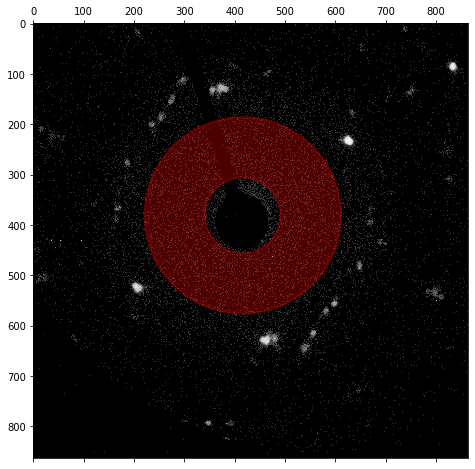

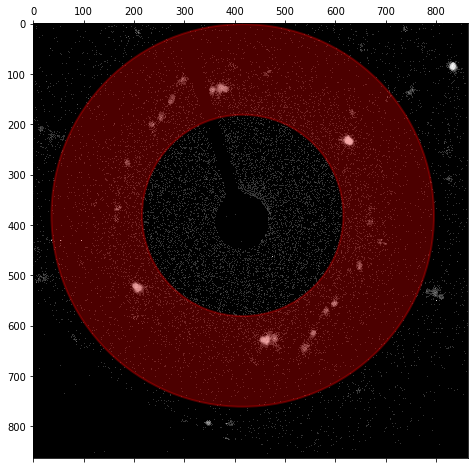

100%|███████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1790.21it/s]


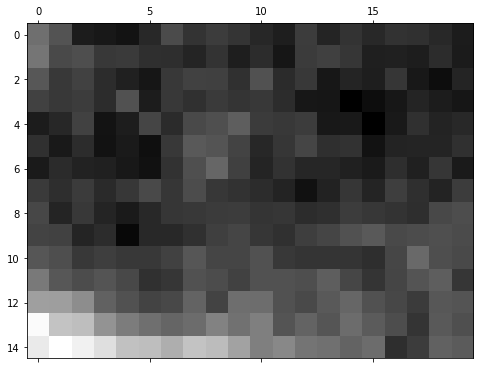

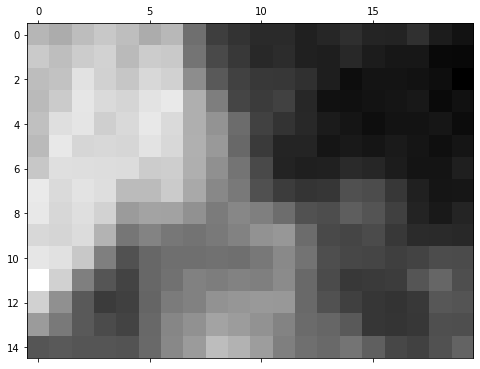

In [8]:
# Get ADF images
center = (381,416)
radii1 = 75,195
radii2 = 200,380

# position detectors
py4DSTEM.visualize.show_annuli(dp_max.data,center,radii1,scaling='log')
py4DSTEM.visualize.show_annuli(dp_max.data,center,radii2,scaling='log')

# get virtual images
adf1 = datacube.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii1),
    name = 'adf1'
)
adf2 = datacube.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii2),
    name = 'adf2'
)

show(adf1.data)
show(adf2.data)

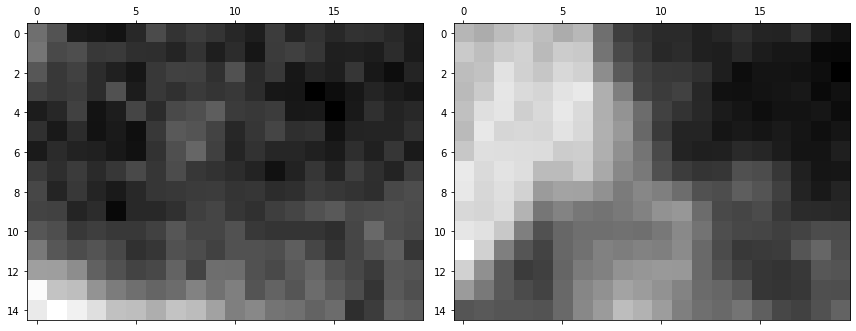

In [9]:
py4DSTEM.visualize.show_image_grid(lambda i:[adf1.data,adf2.data][i],1,2)

## Get the probe template

In [10]:
# Generate a probe template
datacube_vacuum = py4DSTEM.io.read(filepath_vacuum_probe)
datacube_vacuum = py4DSTEM.io.datastructure.DataCube(data=datacube_vacuum[0:10,0:10,:,:])
datacube_vacuum.data.shape

(10, 10, 864, 864)

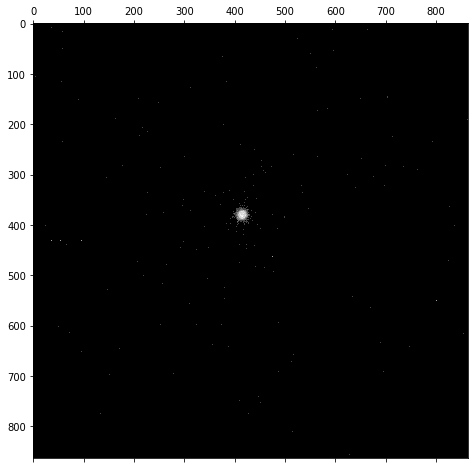

In [11]:
# Examine the 4D calibration dataset
dp_max_vac = datacube_vacuum.get_dp_max()
show(dp_max_vac.data,scaling='log')

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  6.24it/s]


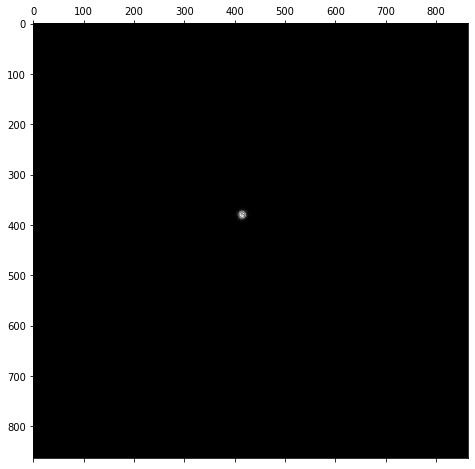

In [12]:
# Get an aligned image of the probe

xmin,xmax = 0,4
ymin,ymax = 0,4

probe = datacube_vacuum.get_vacuum_probe( ROI = (xmin,xmax,ymin,ymax) )

show(probe.probe,scaling='none')

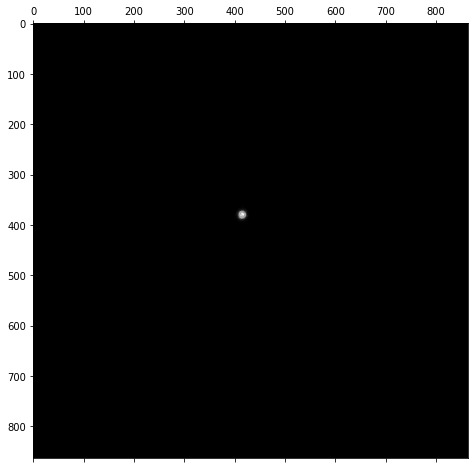

In [13]:
from scipy.ndimage import median_filter
probe.probe = median_filter(probe.probe,size=3)

show( probe.probe, scaling='none' )

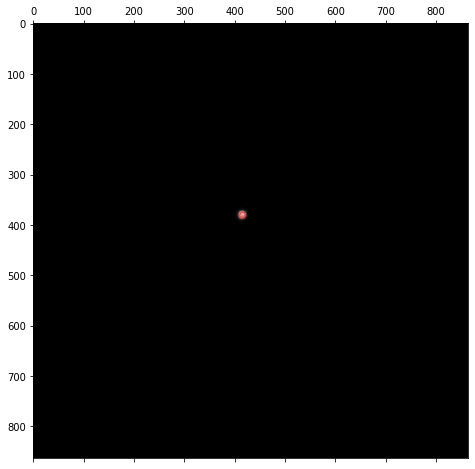

In [14]:
alpha_pix,qx0,qy0 = py4DSTEM.process.calibration.get_probe_size( probe.probe )

py4DSTEM.visualize.show_circles( probe.probe, (qx0,qy0), alpha_pix)

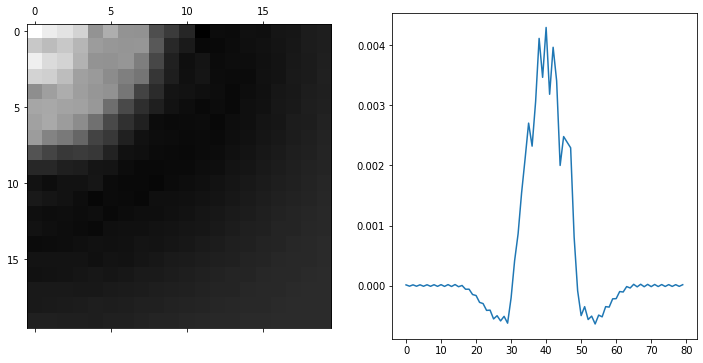

In [15]:
probe_kernel = probe.get_kernel(
    mode = 'sigmoid',
    radii = (0, 4*alpha_pix)
)

py4DSTEM.visualize.show_kernel( probe_kernel, R=20,L=40,W=1 )

## Find bragg disk positions

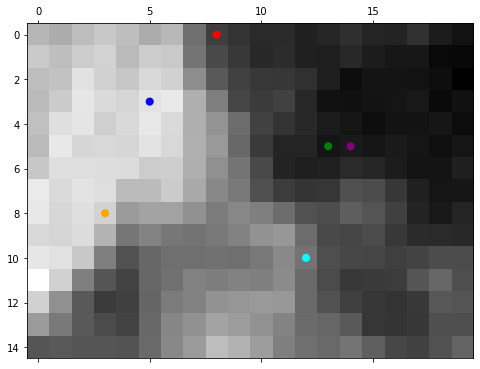

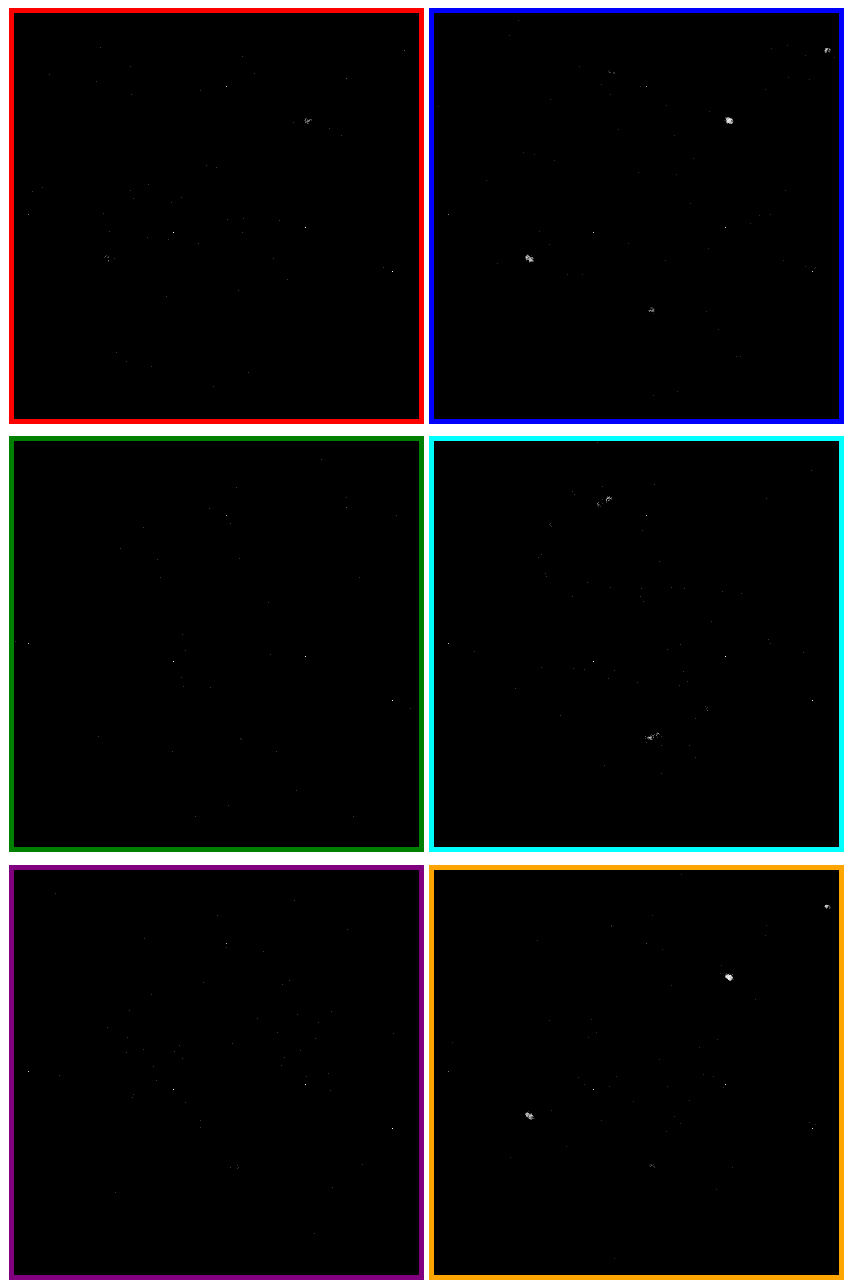

In [16]:
# Select a few DPs on which to test disk detection parameters
rxs = 0,3,5,10,5,8
rys = 8,5,13,12,14,3
colors = ['r','b','g','cyan','purple','orange']

py4DSTEM.visualize.show_points(adf2.data,x=rxs,y=rys,pointcolor=colors,figsize=(8,8))
py4DSTEM.visualize.show_image_grid(get_ar=lambda i:datacube.data[rxs[i],rys[i],:,:],
                                   H=3,W=2,get_bordercolor=lambda i:colors[i],scaling='power',power=0.125)

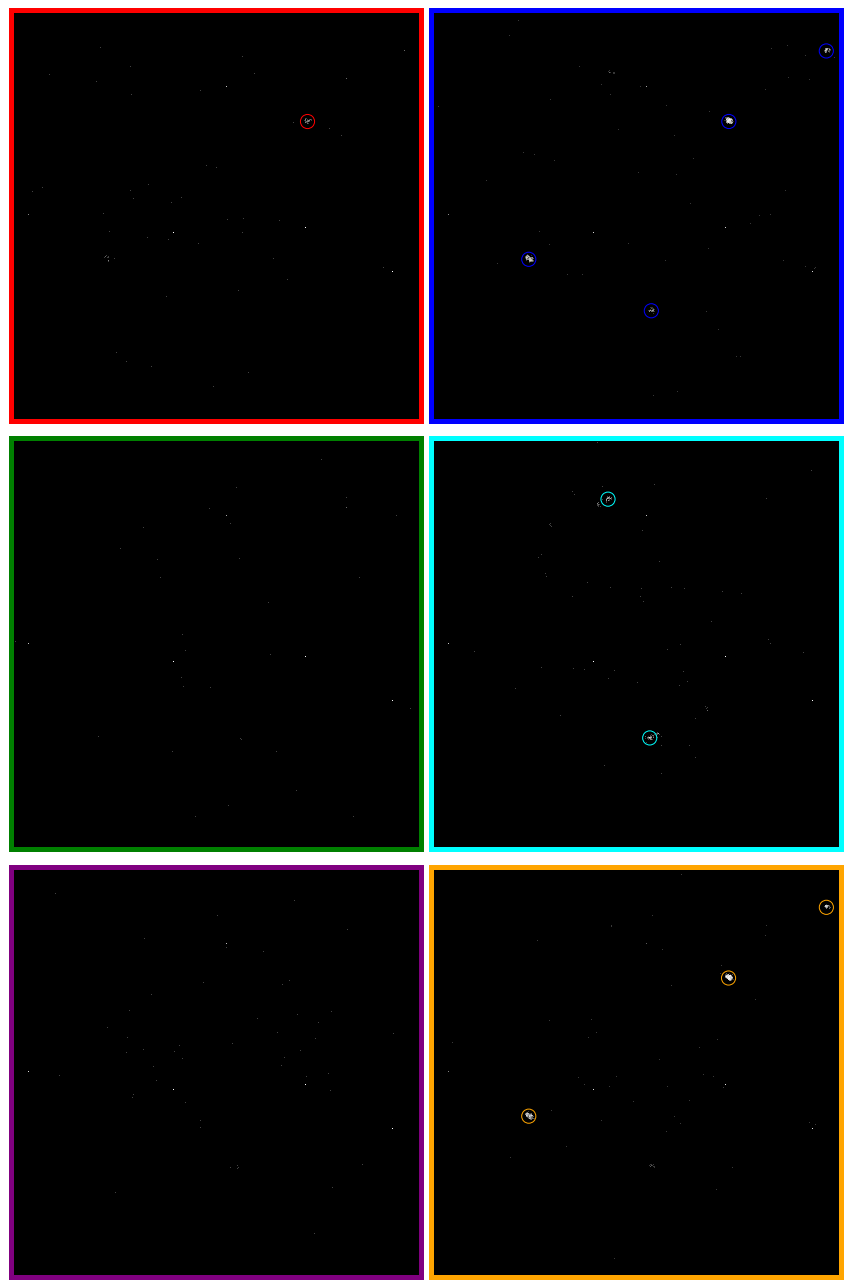

In [17]:
# Tune disk detection parameters on selected DPs

detect_params = {
    'minAbsoluteIntensity':0.65,
    'minPeakSpacing':20,
    'maxNumPeaks':20,
    'subpixel':'poly',
    'sigma':2,
    'edgeBoundary':20,
    'corrPower':1,
}

selected_peaks = datacube.find_Bragg_disks(
    data = (rxs,rys),
    template = probe.kernel,
    **detect_params
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:datacube.data[rxs[i],rys[i],:,:],
    H=3, W=2,
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: selected_peaks[i].data['qx'],
    get_y = lambda i: selected_peaks[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    scaling = 'log',
    open_circles = True,
    scale = 200)

In [18]:
# Get all disks
braggvectors = datacube.find_Bragg_disks(
    template=probe.kernel,
    **detect_params
)

Finding Bragg Disks: 100%|█████████████████████████████████████████████████████████| 300/300 [00:33<00:00, 8.96DP/s]


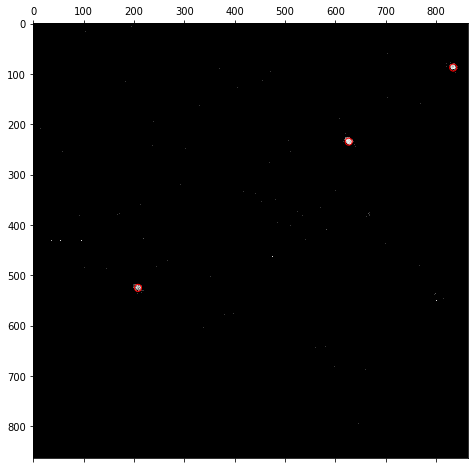

In [19]:
# Show a pattern

rx,ry = 5,1

py4DSTEM.visualize.show_points(
    datacube[rx,ry,:,:],
    scaling='log',
    x = braggvectors.v_uncal[rx,ry]['qx'],
    y = braggvectors.v_uncal[rx,ry]['qy'],
    open_circles = True
)

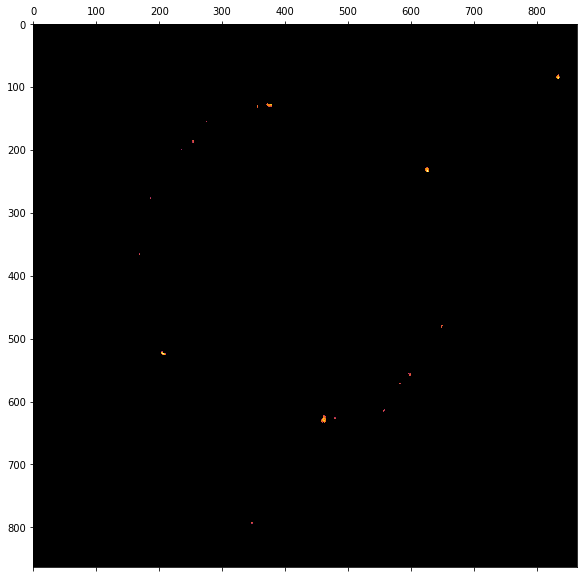

In [20]:
# Get/show a Bragg vector map, a 2D histogram of the localized bragg scattering intensities

bvm = braggvectors.get_bvm(
    Qshape = datacube.Qshape,
    mode = 'raw'
)

# set viz params
bvm_vis_params = {
    'cmap':'inferno',
    'scaling':'power',
    'power':0.125,
    'clipvals':'manual',
    'min':0,
    'max':20    
}
show(bvm,**bvm_vis_params,figsize=(10,10))

## Find the origin

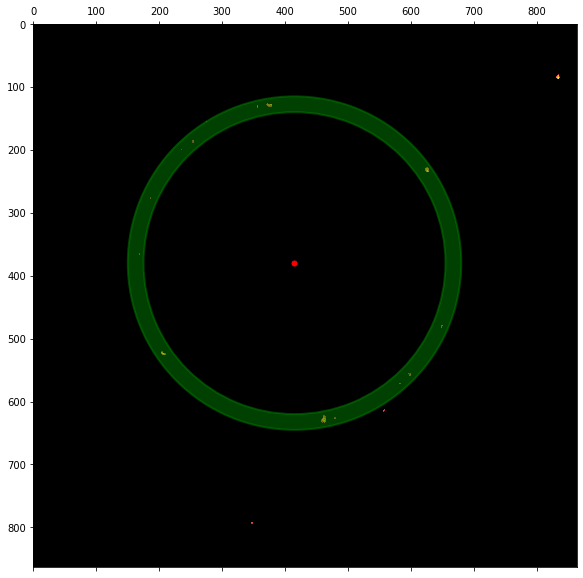

In [21]:
# Because this data had a beamstop blocking the unscattered beam,
# we'll use conjugate bragg pairs to find the origin

# Specify an annular region of Q-space 
center_guess = 380,415
radii = 240,265

show(
    bvm,
    points = {'x':center_guess[0],'y':center_guess[1]},
    annulus = {'center':center_guess,'radii':radii,'fill':True,'alpha':0.5,'color':'g'},
    **bvm_vis_params,
    figsize=(10,10)
)

In [22]:
# Compute the origin position pattern-by-pattern

origin_meas = braggvectors.measure_origin(
    mode = 5,
    center_guess = center_guess,
    radii = radii,
    Q_Nx = datacube.Q_Nx,
    Q_Ny = datacube.Q_Ny,
    max_dist = 16,
    max_iter = 2
)

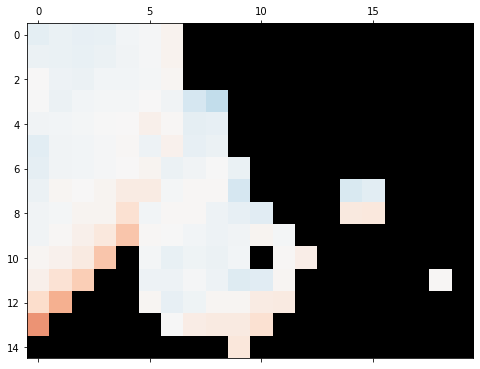

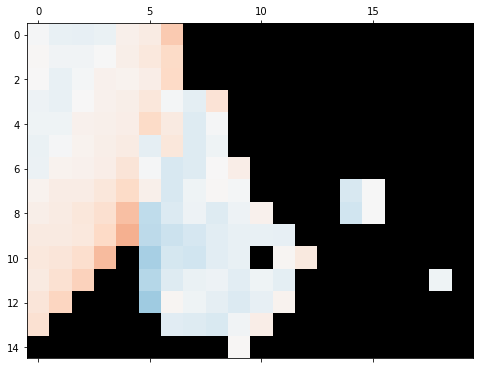

In [23]:
# Show the measured origin shifts

qx0_meas,qy0_meas = origin_meas[0],origin_meas[1]
mask = ~qx0_meas.mask
show(qx0_meas,cmap='RdBu',clipvals='centered',min=np.mean(qx0_meas),max=8)
show(qy0_meas,cmap='RdBu',clipvals='centered',min=np.mean(qy0_meas),max=8)

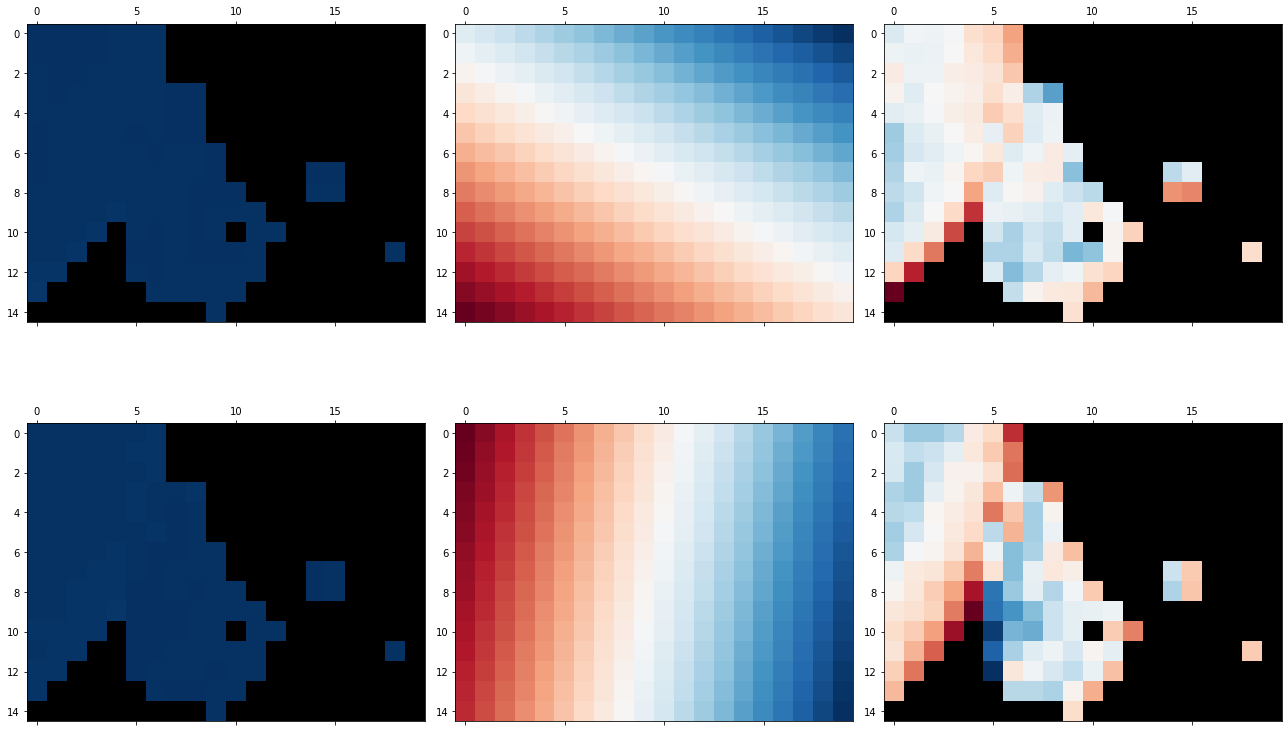

In [24]:
# Some local variation in the position of the origin due to electron-sample interaction is
# expected, and constitutes meaningful signal that we would not want to subtract away.
# In fitting a plane or parabolic surface to the measured origin shifts, we aim to
# capture the systematic shift of the beam due to the changing scan coils,
# while removing as little physically meaningful signal we can.

x = py4DSTEM.process.calibration.fit_origin(
    (qx0_meas,qy0_meas),
    mask=~mask,
    fitfunction='plane')
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = x
py4DSTEM.visualize.show_image_grid(
    lambda i:[qx0_meas,qx0_fit,qx0_residuals,
              qy0_meas,qy0_fit,qy0_residuals][i],
    H=2,W=3,cmap='RdBu',clipvals='centered')

In [25]:
# Calibrate the origin

datacube.calibration.set_origin((qx0_fit,qy0_fit))

In [26]:
# Center the disk positions about the origin

braggvectors.calibrate()

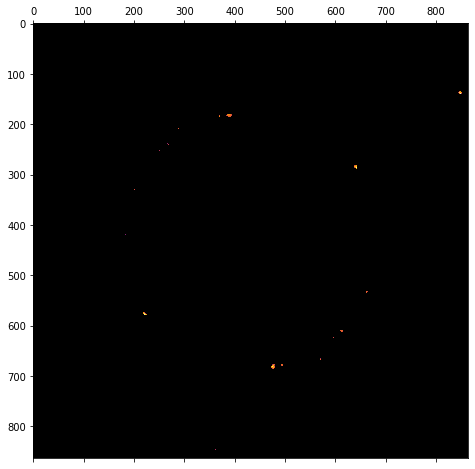

In [27]:
# Centered BVM

bvm_centered = braggvectors.get_bvm(
    Qshape = datacube.Qshape,
)

show(bvm_centered,**bvm_vis_params)

## Elliptical calibration

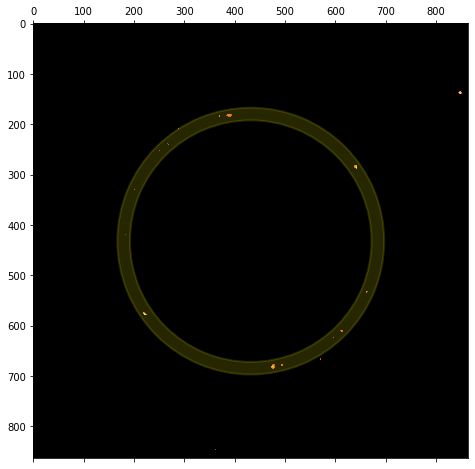

In [28]:
# Select a fitting region

qmin,qmax = 240,265
py4DSTEM.visualize.show(
    bvm_centered,
    **bvm_vis_params,
    annulus={
        'center' : (datacube.Q_Nx/2.,datacube.Q_Ny/2.),
        'radii' : (qmin,qmax),
        'fill' : True,
        'color' : 'y',
        'alpha' : 0.2
    }
)

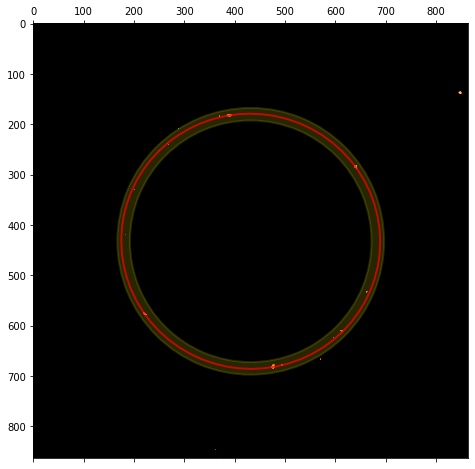

In [29]:
# Fit the elliptical distortions
p_ellipse = py4DSTEM.process.calibration.fit_ellipse_1D(
    bvm_centered,
    (datacube.Q_Nx/2.,datacube.Q_Ny/2.),
    (qmin,qmax)
)
py4DSTEM.visualize.show_elliptical_fit(
    bvm_centered,
    (qmin,qmax),
    p_ellipse,
    **bvm_vis_params
)

In [30]:
# Elliptical calibration

datacube.calibration.set_p_ellipse(p_ellipse)

In [31]:
# Elliptically correct bragg peak positions, stretching the elliptical
# semiminor axis to match the semimajor axis length

braggvectors.calibrate()

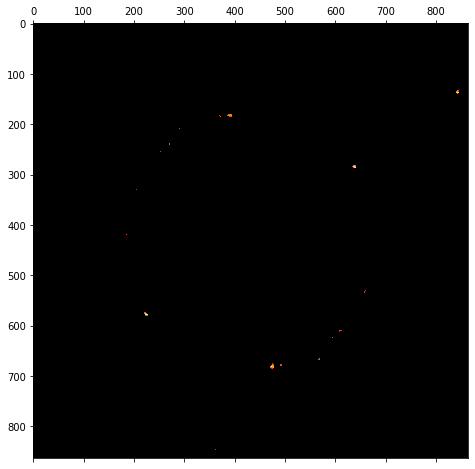

In [32]:
# Recompute the bvm

bvm_ellipsecorr = braggvectors.get_bvm( Qshape=datacube.Qshape )

show(bvm_ellipsecorr,**bvm_vis_params)

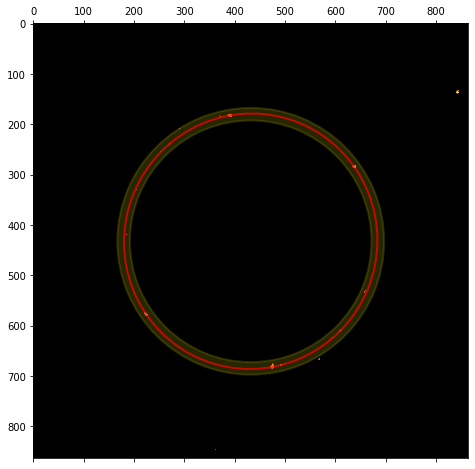

The ratio of the semimajor to semiminor axes was measured to be

	101.52% in the original data and
	101.17% in the corrected data.


In [33]:
# Confirm that elliptical distortions have been removed
# by measuring the ellipticity of the corrected data

p_ellipse_corr = py4DSTEM.process.calibration.fit_ellipse_1D(
    bvm_ellipsecorr,
    p_ellipse[:2],
    (qmin,qmax)
)
py4DSTEM.visualize.show_elliptical_fit(
    bvm_ellipsecorr,
    (qmin,qmax),
    p_ellipse_corr,
    **bvm_vis_params
)

# Print the ratio of the semi-axes before and after correction
print("The ratio of the semimajor to semiminor axes was measured to be")
print("")
print("\t{:.2f}% in the original data and".format(100*p_ellipse[2]/p_ellipse[3]))
print("\t{:.2f}% in the corrected data.".format(100*p_ellipse_corr[2]/p_ellipse_corr[3]))

## Pixel size calibration

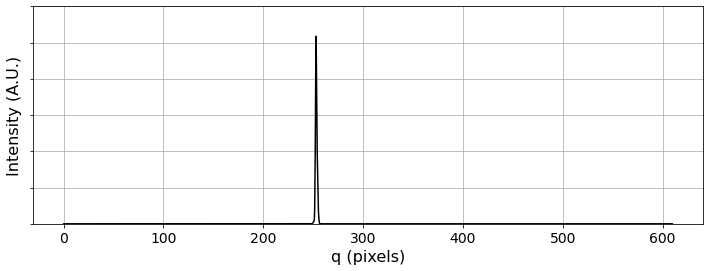

In [34]:
# Radial integration

ymax = 120
dq=0.25             # binsize for the x-axis

q,I_radial = py4DSTEM.process.utils.radial_integral(
    bvm_ellipsecorr,
    datacube.Q_Nx/2,
    datacube.Q_Ny/2,
    dr=dq
)
py4DSTEM.visualize.show_qprofile(q=q,intensity=I_radial,ymax=ymax)

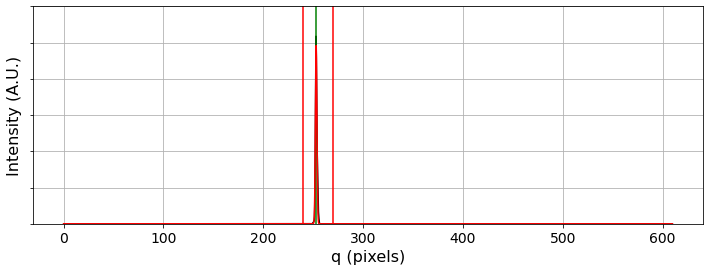

In [35]:
# Fit a gaussian to find a peak location
qmin,qmax = 240,270
A,mu,sigma = py4DSTEM.process.fit.fit_1D_gaussian(q,I_radial,qmin,qmax)

fig,ax = py4DSTEM.visualize.show_qprofile(q=q,intensity=I_radial,ymax=ymax,
                                          returnfig=True)
ax.vlines((qmin,qmax),0,ax.get_ylim()[1],color='r')
ax.vlines(mu,0,ax.get_ylim()[1],color='g')
ax.plot(q,py4DSTEM.process.fit.gaussian(q,A,mu,sigma),color='r')
plt.show()

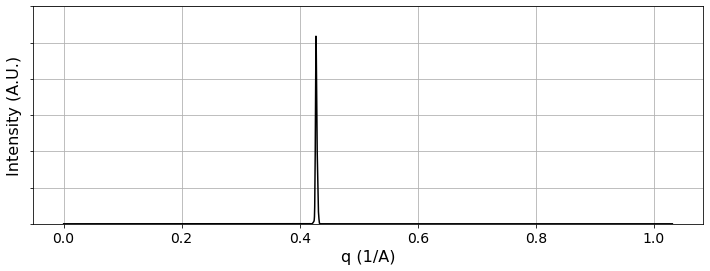

In [36]:
# Get pixel calibration
# At time of writing, one peak with a known spacing
# must be manually identified and entered

d_spacing_A = 2.337                           # This is the Al 111 peak
#d_spacing_A = 2.024                         
inv_A_per_pixel = 1./(d_spacing_A * mu)
py4DSTEM.visualize.show_qprofile(q=q*inv_A_per_pixel,intensity=I_radial,
                                 ymax=ymax,xlabel='q (1/A)')

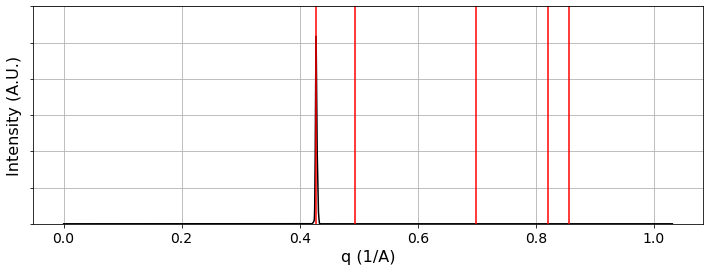

In [37]:
# Demonstrate consistency with known Al spacings

spacings_A = np.array([1.1685,1.22,1.431,2.024,2.337])   # 111, 200, 220, 113, 222
spacings_inv_A = 1./spacings_A

fig,ax = py4DSTEM.visualize.show_qprofile(q=q*inv_A_per_pixel,intensity=I_radial,
                                 ymax=ymax,xlabel='q (1/A)',returnfig=True)
ax.vlines(spacings_inv_A,0,ax.get_ylim()[1],color='r')
plt.show()

In [38]:
# Pixel calibration

datacube.calibration.set_Q_pixel_size(inv_A_per_pixel)
datacube.calibration.set_Q_pixel_units('A^-1')

In [39]:
# Calibrate bragg vector distances

braggvectors.calibrate()

## Save

In [40]:
py4DSTEM.io.save(
    filepath_calibration_h5,
    data = datacube,
    tree = 'noroot',
    mode = 'o'
)

100%|███████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 5843.60it/s]


### Read data

In [41]:
d = py4DSTEM.io.read(
    filepath_calibration_h5,
    root = '4DSTEM_experiment/datacube',
    tree = 'noroot'
)

print(d)

Reading PointListArray: 100%|████████████████████████████████████████████| 300/300 [00:00<00:00, 7365.10PointList/s]


Root( A Root instance called 'root', containing the following top-level object instances:

          calibration 		 (Calibration)
          adf1 		 (VirtualImage)
          adf2 		 (VirtualImage)
          braggvectors 		 (BraggVectors)
          dp_max 		 (DiffractionImage)
          dp_mean 		 (DiffractionImage)
          dp_median 		 (DiffractionImage)
)


In [42]:
cal = d['calibration']
cal

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.001690724779321433
             R_pixel_size:    1
             Q_pixel_units:   A^-1
             R_pixel_units:   pixels
             a:               257.205877731495
             b:               253.3471968204506
             qx0:             2D-array
             qx0_meas:        2D-array
             qy0:             2D-array
             qy0_meas:        2D-array
             theta:           -1.7161669642502626
)

In [66]:
# Calibrate the origin


# a lot actually needs to happen here, i think
# We've made a measurement of the origin, and now we want to apply it to the data.
# what does that include?
# we need to update its value in our datacube's Calibration instance
# we need to update braggvectors.v
# maybe that's all
#
# complication is that there should really be only one function call here, right?
# but we have many objects involved. Calibration, BraggVectors perhaps is it, directly.
# but DataCube should certainly also have a calibrate method, yes? 
# so is that the question here? what `calibrate` methods exist, amongst the data classes,
# and what do they each do.....let's at run with this one for a minute.....
#
# DataCube.calibrate -
# Calibration.calibrate -
# BraggVectors.calibrate -
#
# for each of the three classes, more specific methods...
#
# .calibrate_origin
# .calibrate_ellipse
# .calibrate_pixels
# .calibrate_rotation
#
# ok - Calibration gets the four above methods.  BraggVectors gets its own .calibrate method,
# which looks in Calibration, finds what can be done, and does it. Possibly let DataCube also
# get the Calibration calibration methods exposed to it.



In [ ]:
# get_bvm
#
# this should have some modes, but generally should not need `mode` to be entered
# given sensible defaults. Which should be
# - if there is only `uncal`, get that bvm
# - if there is `cal`, use that
# - ~fin~
#
# still need to think through the sampling stuff, below



# bvm = py4DSTEM.process.diskdetection.get_bragg_vector_map_raw(
#     braggvectors.v_uncal,
#     datacube.Q_Nx,
#     datacube.Q_Ny)

# the bvm needs work
# it is really just a 2D histogram of the peak positions/intensities.
# all there is to specify is the sampling.
# (maybe optional low-pass filtering)
# so the questions are:
#   - what is the space of ways in which this could be sampled?
#   - what do we want the default sampling to be? for cal v. uncal?
#   - what knobs do we want exposed to the user as fn params?